# In this Notebook, we will work on the [**Medical Scan Classification** Dataset](https://www.kaggle.com/datasets/arjunbasandrai/medical-scan-classification-dataset)  

##### Note: This notebook runs **only** on Kaggle, the file paths and directories are configured for Kaggle.. running the code cells won't work unless the dataset is available _locally_ and file paths correctly corresponds to system directories.  

This dataset is all just pictures of kidney samples of patients and non-patients, every pictures is an input sample of $512 \times 512$ pixels, which is a managable size for `Convolutional Neural Networks`.  

First, let's import necessary libraries:  

In [1]:
import kagglehub
import os
import sys
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import absl.logging

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

path = kagglehub.dataset_download("arjunbasandrai/medical-scan-classification-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/medical-scan-classification-dataset


In [2]:
sys.stderr = open('/dev/null', 'w')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
absl.logging.set_verbosity(absl.logging.ERROR)
tf.debugging.set_log_device_placement(False)

I0000 00:00:1734188785.650604      92 service.cc:145] XLA service 0x7a91a0004810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734188785.650654      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734188785.650658      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734188794.674779      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## 1- Data Preprocessing  

It's important to know the structure of the dataset: _you can view it by enabling sidebar from the `view` menu_


The following cell splits the training data into _normal_ and _training_ sets.  
The following cell consolidates all data samples into one big dataset just to be able to convert it into a `pd.DataFrame` to easily manipulate it. This dataset contains only 2 classes: `Normal` and `Tumor` which corresponds to **False** and **True** respectively.

In [3]:
path += "/Kidney Cancer/Kidney Cancer/"
image_paths, labels = [], []

for label_dir in ["Normal", "Tumor"]:  
    class_dir = os.path.join(path, label_dir)
    label = label_dir 
    
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        labels.append(label)

data = pd.DataFrame({"image_path": image_paths, "label": labels})
data["label"].value_counts()

label
Normal    5000
Tumor     5000
Name: count, dtype: int64

The goal of converting the data into a `pd.DataFrame` is to be able to manipulate it easily and use the `train_test_split` function available in scikit-learn library.  
We can use it to split the data twice: into train/test, then the train portion into train/validation; as following:  

In [4]:
from sklearn.model_selection import train_test_split

train_val_data, test_data = train_test_split(data, test_size=0.2, 
                                             stratify=data["label"], random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, 
                                        stratify=train_val_data["label"], random_state=42)

print("Training data:", train_data["label"].value_counts())
print("Validation data:", val_data["label"].value_counts())
print("Testing data:", test_data["label"].value_counts())

Training data: label
Tumor     3000
Normal    3000
Name: count, dtype: int64
Validation data: label
Tumor     1000
Normal    1000
Name: count, dtype: int64
Testing data: label
Normal    1000
Tumor     1000
Name: count, dtype: int64


We need to rescale the input samples to be $224\times224$ as many pre-trained CNN models, _if we end up using one of them_, work with this input size. We also want to _augment_ the data as it increases the diversity of the data, helping the model to generalize well.  
We can do so using the `ImageDataGenerator` class from keras processing images library.  

In [5]:
datagen = ImageDataGenerator(rescale=1.0/255, width_shift_range=0.05, height_shift_range=0.05, 
                             shear_range=0.05, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_dataframe(dataframe=train_data, x_col="image_path", y_col="label", 
                                              target_size=(224, 224), batch_size=32, class_mode="binary")

val_generator = datagen.flow_from_dataframe(dataframe=val_data, x_col="image_path", y_col="label", 
                                              target_size=(224, 224), batch_size=32, class_mode="binary")

test_generator = datagen.flow_from_dataframe(dataframe=test_data, x_col="image_path", y_col="label", 
                                              target_size=(224, 224), batch_size=32, class_mode="binary", shuffle=False)

print("Class indices:", train_generator.class_indices)

Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Class indices: {'Normal': 0, 'Tumor': 1}



## 2- Building the model  

For image classification, a **CNN** model is ideal, or we could also use a pre-trained model like **VGG16**.
A **`Conv2D`** layer is what makes a neural network _convolutional_, it also reduces the number of trainable parameters compared to fully connected **`Dense`** layer.  

A **`BatchNormalization`** layer is often used after a `Conv2D` layer to standardize its activation functions, which leads to faster training by keeping the distribution more stable. It also help make the model generalize well if it's overfitting.  

A **`MaxPooling2D`** layer is essential as it downsamples the spatial dimentions, _height and width_  from the previous layers, while preserving the features. It also prevents overfitting as it reduces the number of parameters.  

A **`Flatten`** layer is used after finishing the custom CNN layers to flatten out the **2D** dimensions into a **1D** feature vector, which is a necessary transformation before feeding the data into a `Dense` layer, _fully connected NN_.  

A **`Dropout`** layer is used to randomly _drop out_ some of the neurons during training. It helps the model generalize better, but in most application when using `BatchNormalization` layers, it's not mandatory to dropout most of the neurons.  

In [6]:
model = Sequential([
    Input(shape=(224, 224, 3)), 
     
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(), 
    
    Dropout(0.45),
    Dense(1, activation='sigmoid'), ])

## 3- Compiling the model  

We're using the `adam` optimizer as it's a standard efficient optimizer for most ML and DL applications.  
We're monitoring the `accuracy` of the model as it helps get a generalized idea of how good the model is, _even if we care more about **recall** in such tasks_.  

In [7]:
adam = tf.keras.optimizers.Adam(learning_rate=2e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,633 (25.99 MB)

 Trainable params: 6,812,417 (25.99 MB)

 Non-trainable params: 1,216 (4.75 KB)

## 4- Training the model  

We're using the `EarlyStopping` technique to avoid the model overfitting the data over a large number of epochs, and then restoring its best parameter depending on lowest `validation_loss`.  

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator,
                    epochs=40, callbacks=[early_stopping])

print(f"Best validation accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 123s 573ms/step - accuracy: 0.8252 - loss: 0.4143 - val_accuracy: 0.5890 - val_loss: 0.6517
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 444ms/step - accuracy: 0.9653 - loss: 0.0945 - val_accuracy: 0.5560 - val_loss: 1.1102
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 443ms/step - accuracy: 0.9828 - loss: 0.0533 - val_accuracy: 0.9700 - val_loss: 0.0925
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 442ms/step - accuracy: 0.9872 - loss: 0.0372 - val_accuracy: 0.9010 - val_loss: 0.2522
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - accuracy: 0.9888 - loss: 0.0376 - val_accuracy: 0.9990 - val_loss: 0.0068
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 445ms/step - accuracy: 0.9970 - loss: 0.0140 - val_accuracy: 0.9960 - val_loss: 0.0110
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 437ms/step - accuracy: 0.9960 - loss: 0.0197 - val_accuracy: 0.9985 - val_loss: 0.0068
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - accuracy: 0.9976 - loss: 

## 5- Model evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 429ms/step
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



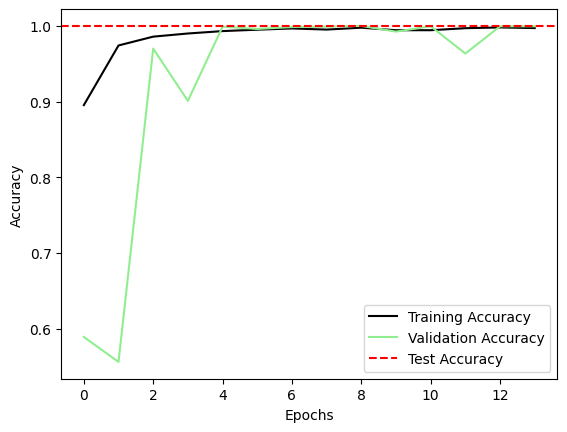

In [9]:
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_generator.classes

accuracy = classification_report(y_true, y_pred, output_dict=True)['accuracy']
print("Test Accuracy: " + str(accuracy) + '\n' + classification_report(y_true, y_pred))

plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lightgreen')
plt.axhline(y=accuracy, color='red', linestyle='--', label="Test Accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Let's plot the **confusion matrix** to see if our classes are balanced across the datasets:  

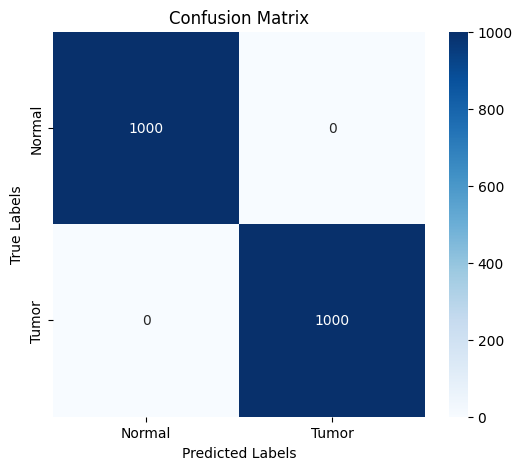

In [10]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### **Now let's save the model**:  

In [11]:
model.save('/kaggle/working/kidney_classifier.h5')